In [1]:
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import sys
import itertools
from collections import namedtuple, defaultdict
from pathlib import Path
from enum import Enum
from os.path import splitext

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 1
%aimport analyze

with open('plots/style.json') as f:
    mpl.rcParams.update(json.load(f))

# Results

## Wildstyle failures

In [2]:
ws = analyze.Analysis('results/wildstyle')
print(ws)

Analysis for Celeritas v0.4.4-rc.1 on wildstyle


In [3]:
ftab = analyze.make_failure_table(ws.failures())
ftab.to_frame()

,Failure
atlas-tilecal/orange+cpu (0),internal assertion failed: `volume` at `Orange...
atlas-tilecal/orange+cpu (1),internal assertion failed: `volume` at `Orange...
atlas-tilecal/orange+gpu (0),"`{""input"":{""_format"":""celer-sim"",""_version"":""0..."
atlas-tilecal/orange+gpu (1),"`{""input"":{""_format"":""celer-sim"",""_version"":""0..."
atlas-tilecal/vecgeom+cpu (0),(unknown failure)
atlas-tilecal/vecgeom+cpu (1),(unknown failure)
cms-hgcal/orange+cpu (0),(unknown failure)
cms-hgcal/orange+cpu (1),(unknown failure)
cms-hgcal/vecgeom+cpu (0),(unknown failure)
cms-hgcal/vecgeom+cpu (1),(unknown failure)


In [4]:
#ftab.to_dict()

In [5]:
ftab['cms2018+field+msc/vecgeom+cpu (0)']

'(unknown failure)'

Unconverged tracks (from runs that didn't fail):

In [6]:
summed = analyze.summarize_instances(ws.result[['unconverged']])
unconv = summed[('unconverged', 'mean')]
unconv[unconv > 0].unstack('arch') 

,arch
problem,geo


## Frontier

In [2]:
frontier = analyze.Analysis('results/frontier')
print(frontier)

Analysis for Celeritas v0.4.4 on frontier


In [3]:
ftab = analyze.make_failure_table(frontier.failures())
ftab.to_frame()

,Failure
atlas-tilecal/orange+cpu (0),`srun: error: frontier10266: task 0: Segmentat...
atlas-tilecal/orange+cpu (1),`srun: error: frontier10266: task 0: Segmentat...
atlas-tilecal/orange+cpu (2),`srun: error: frontier10266: task 0: Segmentat...
atlas-tilecal/orange+cpu (3),`srun: error: frontier10266: task 0: Segmentat...
atlas-tilecal/orange+cpu (4),`srun: error: frontier10266: task 0: Segmentat...
atlas-tilecal/orange+cpu (5),`srun: error: frontier10266: task 0: Segmentat...
atlas-tilecal/orange+cpu (6),`srun: error: frontier10266: task 0: Segmentat...
atlas-tilecal/orange+cpu (7),`srun: error: frontier10266: task 0: Segmentat...
atlas-tilecal/orange+cpu+g4 (0),`srun: error: frontier10266: task 0: Exited wi...
atlas-tilecal/orange+cpu+g4 (1),`srun: error: frontier10266: task 0: Exited wi...


In [4]:
analyze.calc_geo_frac(frontier)

count      mean       std
problem                     geo    arch                           
cms-hgcal                   orange cpu     8.0  0.690871  0.003330
testem15                    orange cpu     8.0  0.432468  0.000540
testem15+field              orange cpu     8.0  0.541663  0.000571
                                   gpu     8.0  0.525873  0.001136
testem15+field+msc          orange cpu     8.0  0.641132  0.000449
testem3-composite+field+msc orange cpu     8.0  0.808700  0.000890
                                   gpu     8.0  0.882265  0.001855
testem3-composite+msc       orange cpu     8.0  0.785401  0.000426
testem3-expanded+field+msc  orange cpu     8.0  0.810939  0.000712
testem3-flat                orange cpu     8.0  0.536340  0.000501
testem3-flat+field          orange cpu     8.0  0.616557  0.002258
testem3-flat+field+msc      orange cpu     8.0  0.763636  0.000384
                                   gpu     8.0  0.820117  0.001682
testem3-flat+msc            orange cpu     8.0  0.729836  0.000395

## Frontier-new

In [8]:
frontier_v050 = analyze.Analysis('results/frontier-v0.5/')
print(frontier_v050)

Analysis for Celeritas v0.5.0-dev.202+141cd4928 on frontier-v0.5


In [9]:
ftab = analyze.make_failure_table(frontier_v050.failures())
ftab.to_frame()

,Failure


In [10]:
analyze.calc_geo_frac(frontier_v050)

count      mean       std
problem                     geo    arch                           
atlas-tilecal               orange cpu     8.0  0.688639  0.006343
cms-hgcal                   orange cpu     8.0  0.691758  0.003234
testem15                    orange cpu     8.0  0.420949  0.001738
testem15+field              orange cpu     8.0  0.532925  0.001342
                                   gpu     8.0  0.517098  0.000689
testem15+field+msc          orange cpu     8.0  0.636258  0.000632
testem3-composite+field+msc orange cpu     8.0  0.810377  0.002835
                                   gpu     8.0  0.902692  0.001695
testem3-composite+msc       orange cpu     8.0  0.784959  0.005576
testem3-expanded+field+msc  orange cpu     8.0  0.812374  0.003818
testem3-flat                orange cpu     8.0  0.535309  0.000774
testem3-flat+field          orange cpu     8.0  0.618430  0.000941
testem3-flat+field+msc      orange cpu     8.0  0.762960  0.000426
                                   gpu     8.0  0.902433  0.003229
testem3-flat+msc            orange cpu     8.0  0.723605  0.009448

## Perlmutter

In [11]:
perlmutter = analyze.Analysis('results/perlmutter')
print(perlmutter)

Analysis for Celeritas v0.4.3-7+0967ac32c on perlmutter


In [12]:
ftab = analyze.make_failure_table(perlmutter.failures())
ftab.to_frame()

,Failure
atlas-tilecal/orange+cpu (0),`srun: error: nid002801: task 0: Segmentation ...
atlas-tilecal/orange+cpu (1),`srun: error: nid002801: task 0: Segmentation ...
atlas-tilecal/orange+cpu (2),`srun: error: nid002801: task 0: Segmentation ...
atlas-tilecal/orange+cpu (3),`srun: error: nid002801: task 0: Segmentation ...
atlas-tilecal/orange+gpu (0),(unknown failure)
atlas-tilecal/orange+gpu (1),(unknown failure)
atlas-tilecal/orange+gpu (2),(unknown failure)
atlas-tilecal/orange+gpu (3),(unknown failure)


# Analysis

## Occupancy

In [13]:
problem = "testem3-flat"
kernel_stats = {
    "cuda/vecgeom": analyze.load_kernels(perlmutter, problem, "vecgeom"),
    "cuda/orange": analyze.load_kernels(perlmutter, problem, "orange"),
    "hip/orange": analyze.load_kernels(frontier, problem, "orange"),
}
ksdf = analyze.kernel_stats_dataframe(kernel_stats)

In [14]:
ksdf[ksdf['local_mem'] > 64]

const_mem  \
arch geo     name                                                     
cuda vecgeom along-step-general-linear-apply-eloss-fluct      20776   
     orange  initialize-tracks                                    0   
             along-step-general-linear-apply-eloss-fluct          0   
             photoel-livermore                                    0   
             annihil-2-gamma                                      0   
             geo-boundary                                         0   
hip  orange  initialize-tracks                                    0   
             geo-boundary                                         0   

                                                            heap_size  \
arch geo     name                                                       
cuda vecgeom along-step-general-linear-apply-eloss-fluct      8388608   
     orange  initialize-tracks                                8388608   
             along-step-general-linear-apply-eloss-fluct      8388608   
             photoel-livermore                                8388608   
             annihil-2-gamma                                  8388608   
             geo-boundary                                     8388608   
hip  orange  initialize-tracks                            68702699520   
             geo-boundary                                 68702699520   

                                                          local_mem  \
arch geo     name                                                     
cuda vecgeom along-step-general-linear-apply-eloss-fluct        104   
     orange  initialize-tracks                                  112   
             along-step-general-linear-apply-eloss-fluct        104   
             photoel-livermore                                   72   
             annihil-2-gamma                                     72   
             geo-boundary                                       152   
hip  orange  initialize-tracks                                  120   
             geo-boundary                                       120   

                                                          max_blocks_per_cu  \
arch geo     name                                                             
cuda vecgeom along-step-general-linear-apply-eloss-fluct                  3   
     orange  initialize-tracks                                            4   
             along-step-general-linear-apply-eloss-fluct                  3   
             photoel-livermore                                            3   
             annihil-2-gamma                                              4   
             geo-boundary                                                 4   
hip  orange  initialize-tracks                                            5   
             geo-boundary                                                 5   

                                                          max_threads_per_block  \
arch geo     name                                                                 
cuda vecgeom along-step-general-linear-apply-eloss-fluct                    256   
     orange  initialize-tracks                                              256   
             along-step-general-linear-apply-eloss-fluct                    256   
             photoel-livermore                                              256   
             annihil-2-gamma                                                256   
             geo-boundary                                                   256   
hip  orange  initialize-tracks                                              256   
             geo-boundary                                                   256   

                                                          max_warps_per_eu  \
arch geo     name                                                            
cuda vecgeom along-step-general-linear-apply-eloss-fluct                24   
     orange  initialize-tracks                   

## Steps

In [31]:
steps = analyze.summarize_instances(frontier.result['avg_steps_per_primary'])

In [32]:
steps.dropna()

count           mean        std
problem                     geo    arch                                     
cms-hgcal                   orange cpu         8.0  133037.283984  36.666026
                                   gpu         8.0  133050.125192  30.773118
testem15                    orange cpu         8.0   30421.699918   2.915033
                                   gpu         8.0   30423.161209   3.875103
testem15+field              orange cpu         8.0   30421.699918   2.915033
                                   gpu         8.0   30423.161209   3.875103
                                   gpu+sync    8.0   30423.161209   3.875103
testem15+field+msc          orange cpu         8.0   30424.789959   2.407697
                                   gpu         8.0   30421.552830   2.127553
testem3-composite+field+msc orange cpu         8.0   77467.821827  44.376923
                                   gpu         8.0   77477.794698  34.081134
                                   gpu+sync    8.0   77477.794698  34.081134
testem3-composite+msc       orange cpu         8.0   77571.060701  19.565410
                                   gpu         8.0   77559.790357  27.324174
testem3-expanded+field+msc  orange cpu         8.0   76285.153118  46.392239
                                   gpu         8.0   76276.244093  36.882391
testem3-flat                orange cpu         8.0   62009.640275  12.727470
                                   gpu         8.0   61994.848228  11.739223
testem3-flat+field          orange cpu         8.0   61170.235027  11.480116
                                   gpu         8.0   61182.627321   7.468682
testem3-flat+field+msc      orange cpu         8.0   72702.759574   9.876216
                                   gpu         8.0   72691.380055  11.967921
                                   gpu+sync    8.0   72691.380055  11.967921
testem3-flat+msc            orange cpu         8.0   72780.971621  11.477399
                                   gpu         8.0   72786.055412  13.508946

In [37]:
(fig, ax) = plt.subplots(figsize=(4, 3), layout="constrained")
frontier.plot_results(ax, steps)
ax.set_ylabel("Steps per primary");
fig.savefig("plots/frontier/steps-per-primary.pdf", transparent=True)
plt.close()

In [38]:
(fig, ax) = plt.subplots(figsize=(4, 3), layout="constrained")
perlmutter.plot_results(ax, analyze.summarize_instances(perlmutter.result['avg_steps_per_primary']))
ax.set_ylabel("Steps per primary");
fig.savefig("plots/perlmutter/steps-per-primary.pdf", transparent=True)
plt.close()

## Geometric complexity

In [60]:
with open('/Users/seth/Documents/work/celeritas-benchmarks/models/summary.json') as f:
    summaries = pd.DataFrame.from_records(json.load(f))
summaries.index = [splitext(fn)[0] for fn in summaries.pop('filename')]

In [61]:
abbreviate_problem = analyze.ProblemAbbreviator()
summaries['label'] = [abbreviate_problem({'geometry_name': k + ".gdml", 'enable_msc': True})
                      for k in summaries.index]

summaries['name'] = {
    "atlas-tilecal": "ATLAS TileCal",
    "cms-hgcal": "CMS HGCal",
    "cms-hllhc": "CMS Run 4 (HL)",
    "cms-run3": "CMS Run 3 (2022)",
    "cms2018": "CMS Run 2 (2018)",
    "dune10kt_v5_refactored_1x2x6": "DUNE A",
    "dunevd10kt_3view_30deg_v6_refactored_1x8x6": "DUNE B",
    "simple-cms": "Simple CMS",
    "testem15": "Infinite",
    "testem3-composite": "TestEm3 (composite)",
    "testem3-expanded": "TestEm3 (expanded)",
    "testem3-flat": "TestEM3 (flat)",
    "trackml": "TrackML",
    "zdcgeom": "ALICE ZDC",
    "atlas-emec": "ATLAS EMEC",
    "atlas-emec-nogaps": "ATLAS EMEC (filled gaps)",
}

In [62]:
summaries

,isotope,element,material,logical,physical,label,name
atlas-emec,25,9,12,281,40782,A$_\mathrm{E}$,ATLAS EMEC
atlas-emec-nogaps,25,9,12,353,80718,A$_\mathrm{E}^*$,ATLAS EMEC (filled gaps)
cms-hgcal,45,16,19,893,24506,C$_\mathrm{HG}$,CMS HGCal
atlas-tilecal,33,13,11,199,680,A$_\mathrm{T}$,ATLAS TileCal
cms-hllhc,111,37,452,10884,46009,C$_\mathrm{R4}$,CMS Run 4 (HL)
cms-run3,123,41,391,4147,27003,C$_\mathrm{R3}$,CMS Run 3 (2022)
cms2018,122,40,385,3815,19173,C$_\mathrm{R2}$,CMS Run 2 (2018)
dune10kt_v5_refactored_1x2x6,0,21,46,3831,6363,D$_A$,DUNE A
dunevd10kt_3view_30deg_v6_refactored_1x8x6,0,21,47,592,1145,D$_B$,DUNE B
simple-cms,20,6,6,7,7,T$_\mathrm{SC}$,Simple CMS


In [63]:
class Status(Enum):
    untested = [0,0,0,0.25]
    full = "tab:orange"
    nomsc = "tab:green"
    vecgeom = "tab:blue"

In [64]:
status = {
  "testem15": Status.full,
  "testem3-flat": Status.full,
  "testem3-composite": Status.full,
  "testem3-expanded": Status.full,
  "simple-cms": Status.full,
  "atlas-emec": Status.vecgeom,
  "atlas-tilecal": Status.nomsc,
  "simple-cms": Status.full,
  "cms-hgcal": Status.nomsc,
  "cms2018": Status.vecgeom,
  "cms-run3": Status.untested,
  "cms-hllhc": Status.untested,
#  "dune10kt_v5_refactored_1x2x6": Status.untested,
#  "dunevd10kt_3view_30deg_v6_refactored_1x8x6": Status.untested,
  "trackml": Status.untested,
  "zdcgeom": Status.untested,
}

In [65]:
ps = summaries.loc[list(status.keys()),:]

In [66]:
(fig, ax) = plt.subplots(subplot_kw=dict(xscale='log', yscale='log'))
scat = ax.scatter([ps['logical'] + ps['physical']],
                  [ps['element'] + ps['material']],
                  marker='.', color = np.array([s.value for s in status.values()], dtype=object))
ax.set_xlabel("Logical + physical volumes")
ax.set_ylabel("Element + materials")
lo, hi = ax.get_xlim()
ax.set_xlim([lo, hi * 2])
ax.grid(which='major')
for lab, off, s in zip(ps['label'], scat.get_offsets(), status.values()):
    ax.annotate(lab, off, annotation_clip=False,
                color=([0,0,0,0.5] if status == Status.untested else 'k'))
fig.savefig("plots/problem-complexity.png", dpi=300)
plt.close()

In [67]:
temp = ps.loc[:, ['name', 'label']]
temp.index = temp.pop('name')
temp

,label
name,
Infinite,T$_\mathrm{inf}$
TestEM3 (flat),T$_\mathrm{EM3}^-$
TestEm3 (composite),T$_\mathrm{EM3}^+$
TestEm3 (expanded),T$_\mathrm{EM3}^*$
Simple CMS,T$_\mathrm{SC}$
ATLAS EMEC,A$_\mathrm{E}$
ATLAS TileCal,A$_\mathrm{T}$
CMS HGCal,C$_\mathrm{HG}$
CMS Run 2 (2018),C$_\mathrm{R2}$


## Performance drop between versions

In [28]:
analyses = {a.version: a for a in [frontier, frontier_v050]}
analyses['0.5.0'] = analyses.pop('0.5.0-dev.202+141cd4928')
throughput = {k: analyze.summarize_instances(a.result['avg_event_per_time']) for k, a in analyses.items()}

In [42]:
steps = {k: analyze.summarize_instances(a.result['avg_steps_per_primary']) for k, a in analyses.items()}

In [54]:
def plot_ratio(result_dict):
    rel = analyze.calc_summary_ratio(result_dict['0.5.0'], result_dict['0.4.4'])
    fig, ax = plt.subplots(layout="constrained")
    frontier_v050.plot_results(ax, rel)
    ax.grid(which='both')
    ax.legend()
    return ax

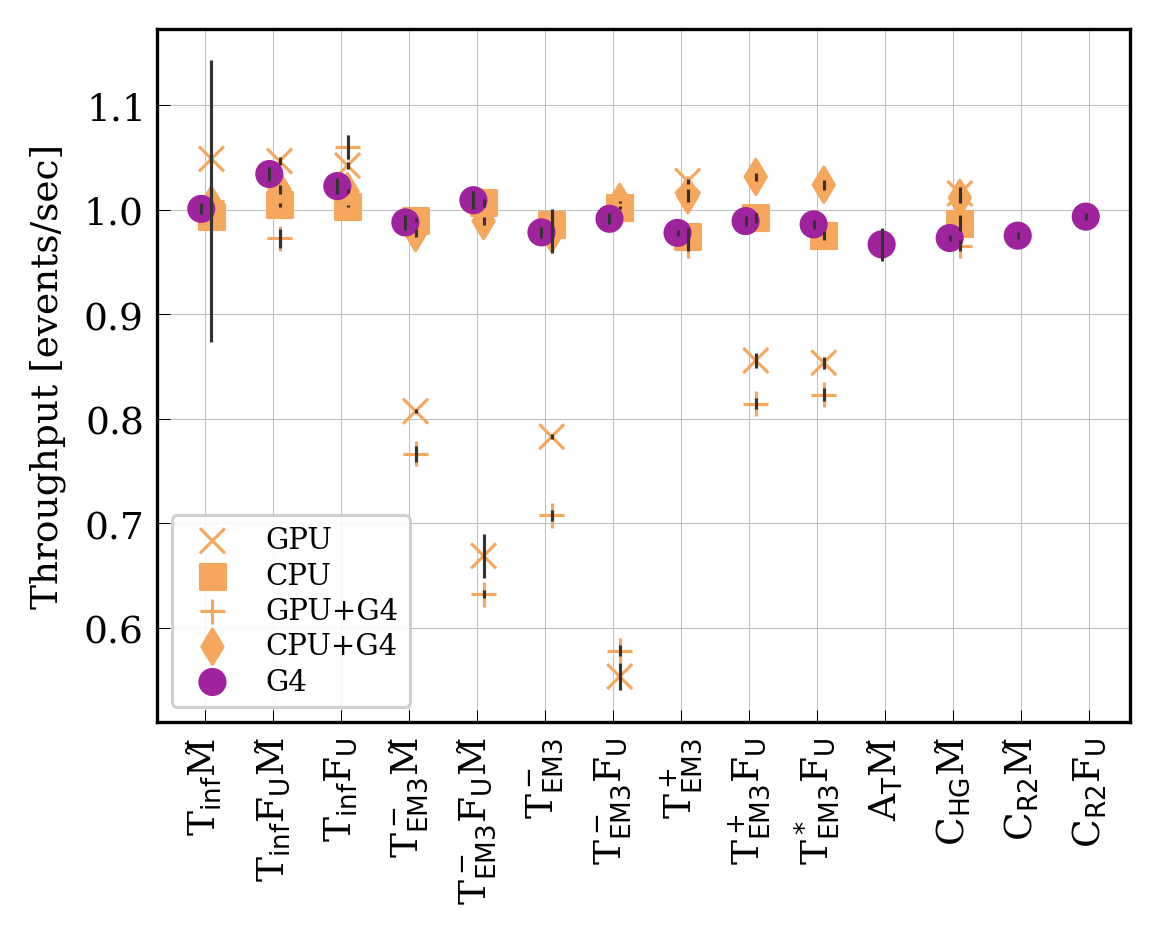

In [58]:
ax = plot_ratio(throughput)
ax.set_ylabel(f"Throughput [events/sec]")
ax.get_figure().savefig('throughput.png', dpi=300)

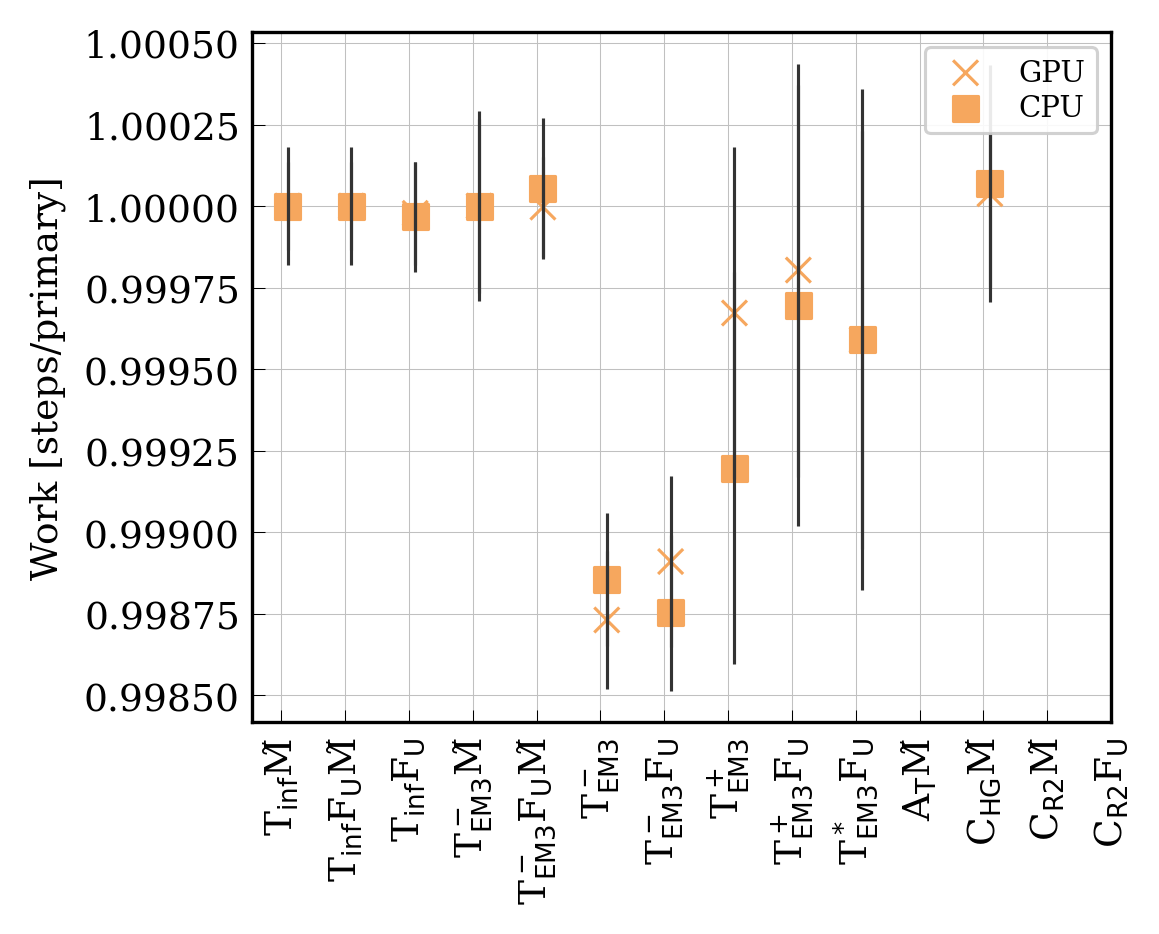

In [57]:
ax = plot_ratio(steps)
ax.set_ylabel(f"Work [steps/primary]")
ax.get_figure().savefig('work.png', dpi=300)